In [3]:
!pip install yfinance numpy pandas matplotlib hmmlearn scikit-learn seaborn
!pip install pomegranate



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: C:\Users\muskan\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: C:\Users\muskan\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


Part 1: Data Collection and Preprocessing


Download historical financial data from a reliable source like Yahoo Finance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
ticker = "AAPL"     
start = "2014-01-01"
end = "2025-11-07"

# Download
df = yf.download(ticker, start=start, end=end, progress=False)


C:\Users\muskan\AppData\Local\Temp\ipykernel_228668\3205776022.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


In [12]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2014-01-02,17.173330,17.294416,17.138868,17.252502,234684800
2014-01-03,16.796103,17.191026,16.779026,17.164948,392467600
2014-01-06,16.887693,16.976799,16.566972,16.686506,412610800
2014-01-07,16.766922,16.950723,16.701101,16.899805,317209200
2014-01-08,16.873102,16.938301,16.725006,16.728730,258529600


In [13]:
print(df.columns)


MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


PreProcessing

In [14]:
df.columns = [col[0] for col in df.columns]


 Extract the relevant features for modeling, such as daily adjusted closing prices. 

In [15]:
adj_close = df['Close']

Calculate the daily returns from the adjusted closing prices

In [16]:
daily_returns = adj_close.pct_change().dropna()
daily_returns = daily_returns.replace([np.inf, -np.inf], np.nan).dropna()


In [17]:
print(daily_returns.head())
print(daily_returns.describe())


Date
2014-01-03   -0.021966
2014-01-06    0.005453
2014-01-07   -0.007151
2014-01-08    0.006333
2014-01-09   -0.012770
Name: Close, dtype: float64
count    2980.000000
mean        0.001085
std         0.017918
min        -0.128647
25%        -0.007063
50%         0.000994
75%         0.010037
max         0.153289
Name: Close, dtype: float64


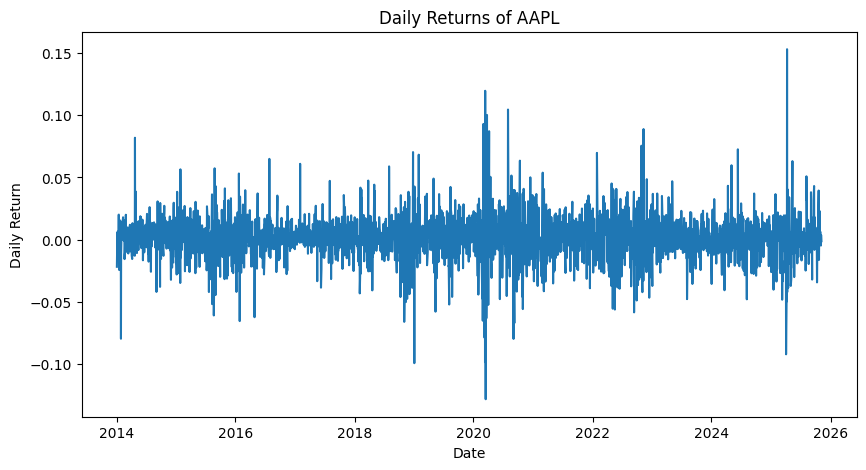

In [60]:
plt.figure(figsize=(10,5))
plt.plot(daily_returns)
plt.title('Daily Returns of AAPL')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()


In [61]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# drop NaNs just in case
returns = daily_returns.dropna()

# HMM expects shape (n_samples, n_features) — here n_features = 1 (daily return)
X = returns.values.reshape(-1, 1)
N = X.shape[0]


k = (n_components - 1)                      # initial state probabilities (one constrained)
  + n_components * (n_components - 1)      # transition matrix rows each sum to 1
  + n_components * D                       # means (D dimensions)
  + n_components * D                       # covariances (diag, D dims)

Part 2: Gaussian Hidden Markov Model


In [41]:
from math import log
def compute_bic(hmm_model, X):
    logL = hmm_model.score(X)  # total log likelihood
    n = hmm_model.n_components
    D = X.shape[1]
    k = (n - 1) + n * (n - 1) + n * D + n * D
    bic = -2 * logL + k * np.log(X.shape[0])
    return bic, logL


Fitting the Model: 

In [ ]:
from hmmlearn.hmm import GaussianHMM
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

results = {}
n_states = 2
model = GaussianHMM(
    n_components=n_states,
    covariance_type='diag',
    n_iter=200,
    random_state=42,
    verbose=False
)
model.fit(X)

# Evaluate
bic, logL = compute_bic(model, X)

print(f"States = {n_states}")
print(f"BIC = {bic:.2f}")
print(f"Log-Likelihood = {logL:.2f}")

best_n = n_states
best_model = model


States = 2
BIC = -16189.03
Log-Likelihood = 8122.52


Parameter Analysis: 

In [63]:
# Viterbi path (most likely state sequence)
hidden_states = best_model.predict(X)  # length N, values in range(best_n)

# posterior probabilities (optional)
# post_probs = best_model.predict_proba(X)

# state-wise mean and variance (from model params)
means = best_model.means_.flatten()         # shape (n_states,)
vars_ = best_model.covars_.flatten()        # diag covars -> 1-D
transmat = best_model.transmat_


print("State means (daily returns):", means)
print("State variances:", vars_)
print("Transition matrix:\n", transmat)

# Create a dataframe for analysis
df_states = pd.DataFrame({
    'date': returns.index,
    'return': returns.values,
    'state': hidden_states
}).set_index('date')




State means (daily returns): [ 0.00145529 -0.00017376]
State variances: [0.00014111 0.00095958]
Transition matrix:
 [[0.95750107 0.04249893]
 [0.14437968 0.85562032]]


Part 3: Interpretation and Inference 

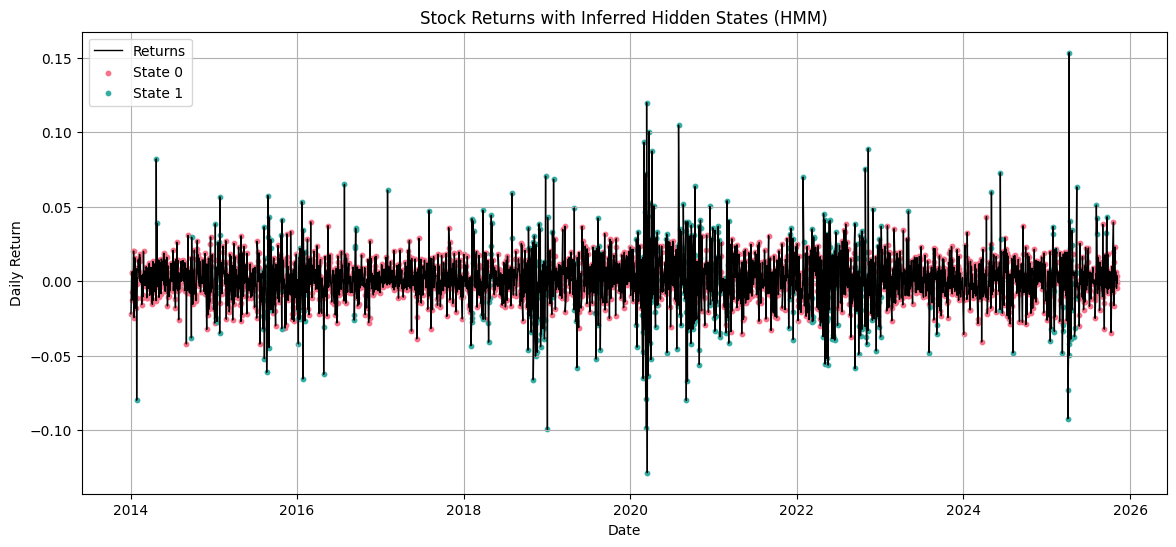

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create color palette for hidden states
num_states = best_model.n_components
palette = sns.color_palette("husl", num_states)

plt.figure(figsize=(14, 6))

# Plot returns
plt.plot(df_states.index, df_states['return'], color='black', linewidth=1.0, label='Returns')

# Color regions by hidden state
for i, state in enumerate(range(num_states)):
    state_mask = df_states['state'] == state
    plt.scatter(df_states.index[state_mask], 
                df_states['return'][state_mask],
                s=10, color=palette[i], label=f'State {state}')

plt.title("Stock Returns with Inferred Hidden States (HMM)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.show()


Part 4: Evaluation and Visualization

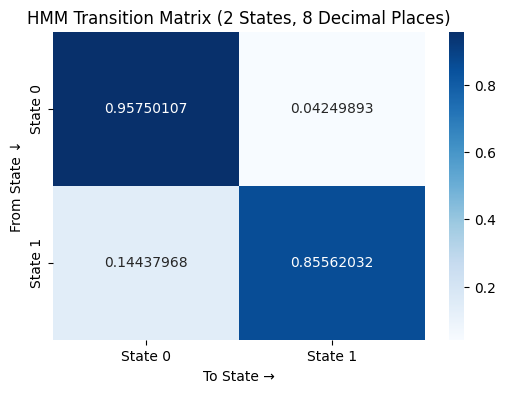

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# For your 2-state HMM
num_states = 2
transmat_8 = np.round(best_model.transmat_, 8)  # rounded to 8 decimals

plt.figure(figsize=(6, 4))
sns.heatmap(
    transmat_8,
    annot=True,
    cmap="Blues",
    fmt=".8f",
    xticklabels=[f"State {i}" for i in range(num_states)],
    yticklabels=[f"State {i}" for i in range(num_states)]
)
plt.title("HMM Transition Matrix (2 States, 8 Decimal Places)")
plt.xlabel("To State →")
plt.ylabel("From State ↓")
plt.show()


In [66]:
# Compute summary stats per state
state_summary = df_states.groupby('state')['return'].agg(['count', 'mean', 'std', 'min', 'max'])
print(state_summary)

       count      mean       std       min       max
state                                               
0       2419  0.001336  0.011981 -0.042294  0.043271
1        561  0.000002  0.032963 -0.128647  0.153289


Future State Prediction:

In [67]:
last_state = hidden_states[-1]
print(f"Most recent hidden state: State {last_state}")

# One-step ahead probabilities
next_state_probs = best_model.transmat_[last_state]
print("\nPredicted probability of next-day market state:")
for i, p in enumerate(next_state_probs):
    print(f"  State {i}: {p:.8f}")


Most recent hidden state: State 0

Predicted probability of next-day market state:
  State 0: 0.95750107
  State 1: 0.04249893


Extend the Gaussian HMM to include more than two hidden states to capture more complex market behavior, such as extreme volatility periods or stable growth phases

In [68]:
from hmmlearn.hmm import GaussianHMM
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

results = {}
for n_states in range(2, 6):   # try 2..5 states (change range if you want more)
    model = GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=200, random_state=42, verbose=False)
    model.fit(X)
    bic, logL = compute_bic(model, X)
    results[n_states] = {'model': model, 'bic': bic, 'logL': logL}

# show BICs
for n, r in results.items():
    print(f"states={n}  BIC={r['bic']:.1f}   logL={r['logL']:.1f}")

# pick best
best_n = min(results, key=lambda k: results[k]['bic'])
best_model = results[best_n]['model']
print(f"Best number of states by BIC: {best_n}")


states=2  BIC=-16189.0   logL=8122.5
states=3  BIC=-16134.8   logL=8123.4
states=4  BIC=-16223.5   logL=8203.7
states=5  BIC=-16103.6   logL=8187.8
Best number of states by BIC: 4


In [71]:
# Viterbi path (most likely state sequence)
hidden_states = best_model.predict(X)  # length N, values in range(best_n)

# posterior probabilities (optional)
# post_probs = best_model.predict_proba(X)

# state-wise mean and variance (from model params)
means = best_model.means_.flatten()         # shape (n_states,)
vars_ = best_model.covars_.flatten()        # diag covars -> 1-D
transmat = best_model.transmat_


print("State means (daily returns):", means)
print("State variances:", vars_)
print("Transition matrix:\n", transmat)

# Create a dataframe for analysis
df_states = pd.DataFrame({
    'date': returns.index,
    'return': returns.values,
    'state': hidden_states
}).set_index('date')




State means (daily returns): [ 2.57097181e-03  1.15892470e-05  1.59218274e-03 -3.08695158e-03]
State variances: [0.00072867 0.00044364 0.00010792 0.00313204]
Transition matrix:
 [[3.81642508e-01 9.26087570e-07 6.18356494e-01 7.21392956e-08]
 [4.80951727e-03 9.74624900e-01 9.77595151e-03 1.07896317e-02]
 [8.25521412e-02 7.38315894e-03 9.10064699e-01 1.28459626e-09]
 [4.35578383e-04 1.32012864e-01 3.71335976e-07 8.67551186e-01]]


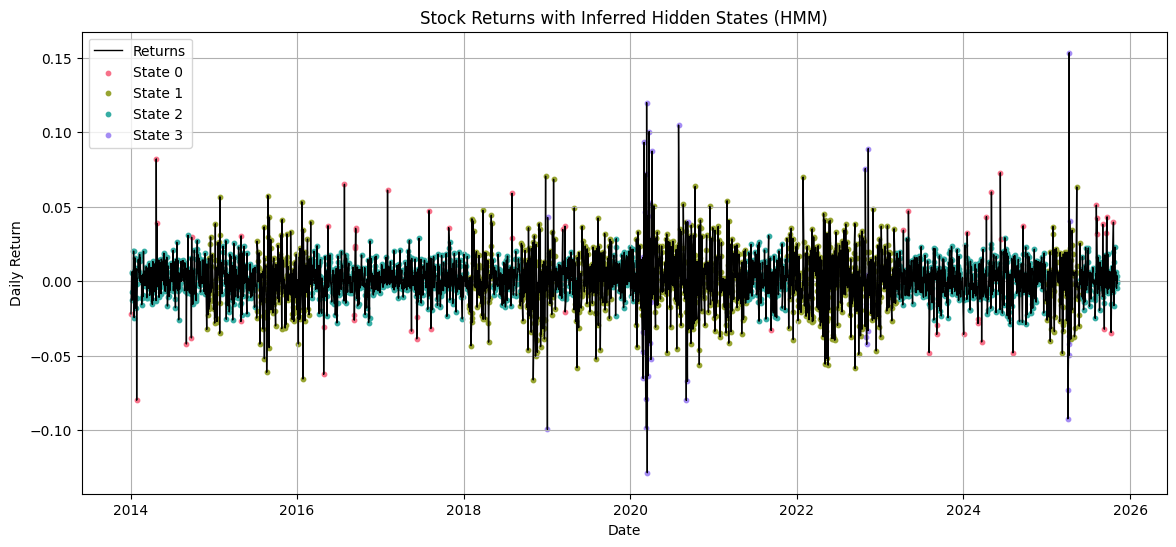

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create color palette for hidden states
num_states = best_model.n_components
palette = sns.color_palette("husl", num_states)

plt.figure(figsize=(14, 6))

# Plot returns
plt.plot(df_states.index, df_states['return'], color='black', linewidth=1.0, label='Returns')

# Color regions by hidden state
for i, state in enumerate(range(num_states)):
    state_mask = df_states['state'] == state
    plt.scatter(df_states.index[state_mask], 
                df_states['return'][state_mask],
                s=10, color=palette[i], label=f'State {state}')

plt.title("Stock Returns with Inferred Hidden States (HMM)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.show()


In [76]:
transmat_8 = np.round(best_model.transmat_, 8) 

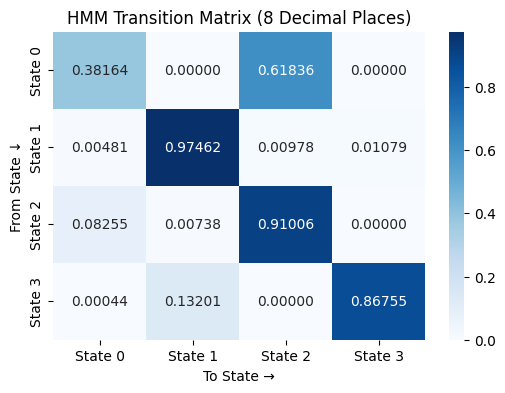

In [77]:
plt.figure(figsize=(6, 4))
sns.heatmap(transmat_8, annot=True, cmap="Blues", fmt=".5f",
            xticklabels=[f'State {i}' for i in range(num_states)],
            yticklabels=[f'State {i}' for i in range(num_states)])
plt.title("HMM Transition Matrix (8 Decimal Places)")
plt.xlabel("To State →")
plt.ylabel("From State ↓")
plt.show()


In [78]:
# Compute summary stats per state
state_summary = df_states.groupby('state')['return'].agg(['count', 'mean', 'std', 'min', 'max'])
print(state_summary)

       count      mean       std       min       max
state                                               
0         58  0.007761  0.040701 -0.079927  0.081982
1       1209  0.000408  0.020013 -0.066331  0.070422
2       1658  0.001536  0.010071 -0.029142  0.030717
3         55 -0.004671  0.061583 -0.128647  0.153289


In [79]:
last_state = hidden_states[-1]
print(f"Most recent hidden state: State {last_state}")

# One-step ahead probabilities
next_state_probs = best_model.transmat_[last_state]
print("\nPredicted probability of next-day market state:")
for i, p in enumerate(next_state_probs):
    print(f"  State {i}: {p:.8f}")


Most recent hidden state: State 2

Predicted probability of next-day market state:
  State 0: 0.08255214
  State 1: 0.00738316
  State 2: 0.91006470
  State 3: 0.00000000
